## Installing pulp if necessary

In [1]:
!pip install pulp

## Importing the libraries

In [2]:
import numpy as np
import pulp
import pandas as pd
import itertools
import time
import math
import matplotlib.pyplot as plt

## Generating the VRP

In [3]:
def GenerateVRPInstance(num_customers = 10, seed = 1):
  """These instances are based on the Solomon's RC2 instances"""
  np.random.seed(seed)
  ready_times = (np.random.rand(num_customers)*45).reshape((num_customers,1)) # Generate the ready times for the customers
  x_locations = (np.random.rand(num_customers)).reshape((num_customers,1))
  y_locations = (np.random.rand(num_customers)).reshape((num_customers,1))
  demand = (np.random.randint(1,9,num_customers).reshape((num_customers,1))).reshape((num_customers,1))/10
  window_length = 3
  service_time = ((np.random.rand(num_customers)).reshape((num_customers,1))).reshape((num_customers,1))
  depot_location = np.array([40,50])
  VRP = np.concatenate((np.concatenate((np.concatenate((np.concatenate((np.concatenate((x_locations,y_locations), axis=1),ready_times),axis=1),(ready_times + window_length)),axis=1),demand),axis=1),service_time),axis=1)
  VRP = VRP.reshape((num_customers,6))
  VRP[0,4] = 0 # Set the demand of the depot to 0
  return VRP

## Define the variables

In [4]:
# customer count ('0' is depot) 
customer_count = 11

# the number of vehicles
vehicle_count = 4

# the capacity of vehicles
vehicle_capacity = 3

# the total service time
T = 48

seed = 1

# Got to determine the distance matrix
VRP = GenerateVRPInstance(customer_count, seed) # Generate an instance of the capacitated vehicle routing problem with time windows (CVRPTW)
distance = np.zeros((customer_count,customer_count))
for i in range(customer_count):
  for j in range(customer_count):
    distance[i, j] = ((VRP[i,0]-VRP[j,0])**2+(VRP[i,1]-VRP[j,1])**2)**0.5

df = pd.DataFrame(VRP)
df.columns = ['longitude','latitude','start_time', 'end_time', 'demand', 'service_time']
print(df)

    longitude  latitude  start_time   end_time  demand  service_time
0    0.685220  0.313424   18.765990  21.765990     0.0      0.034171
1    0.204452  0.692323   32.414602  35.414602     0.4      0.624030
2    0.878117  0.876389    0.005147   3.005147     0.5      0.660636
3    0.027388  0.894607   13.604966  16.604966     0.1      0.298495
4    0.670468  0.085044    6.604015   9.604015     0.2      0.446135
5    0.417305  0.039055    4.155237   7.155237     0.4      0.222125
6    0.558690  0.169830    8.381710  11.381710     0.5      0.073364
7    0.140387  0.878143   15.550233  18.550233     0.3      0.469239
8    0.198101  0.098347   17.854536  20.854536     0.5      0.096172
9    0.800745  0.421108   24.246753  27.246753     0.1      0.903370
10   0.968262  0.957890   18.863753  21.863753     0.6      0.119490


## Building and solving the linear program

Vehicle Requirements: 2
Moving Distance: 4.0526532028982984
0th Optimisation took 0.28823065757751465 seconds
Vehicle Requirements: 2
Moving Distance: 3.721104084687311
1th Optimisation took 6.136100769042969 seconds
Vehicle Requirements: 2
Moving Distance: 2.780421052936862
2th Optimisation took 0.9195699691772461 seconds
Vehicle Requirements: 2
Moving Distance: 3.1400791796907566
3th Optimisation took 6.081760406494141 seconds
Vehicle Requirements: 2
Moving Distance: 3.87308962741197
4th Optimisation took 6.232846736907959 seconds
Vehicle Requirements: 2
Moving Distance: 3.090192580928026
5th Optimisation took 7.146780014038086 seconds
Vehicle Requirements: 2
Moving Distance: 3.471758705525115
6th Optimisation took 7.489467620849609 seconds
Vehicle Requirements: 2
Moving Distance: 3.6430141442044555
7th Optimisation took 8.286640405654907 seconds
Vehicle Requirements: 2
Moving Distance: 3.391797891804933
8th Optimisation took 0.8689274787902832 seconds
Vehicle Requirements: 2
Moving 

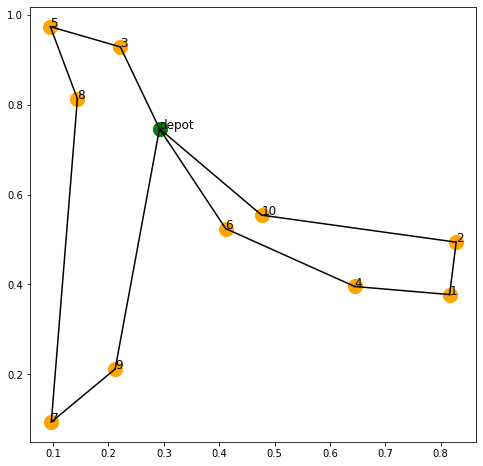

In [5]:
result = np.zeros(100)
for p in range(100):
  # Got to determine the distance matrix
  VRP = GenerateVRPInstance(customer_count, p) # p sets the seed for comparability of the results
  distance = np.zeros((customer_count,customer_count)) 
  for i in range(customer_count):
    for j in range(customer_count):
      distance[i, j] = ((VRP[i,0]-VRP[j,0])**2+(VRP[i,1]-VRP[j,1])**2)**0.5

  # Packaging the VRP into a pandas dataframe
  df = pd.DataFrame(VRP)
  df.columns = ['longitude','latitude','start_time', 'end_time', 'demand', 'service_time']
  # solve with pulp
  for vehicle_count in range(1,vehicle_count+2):
      
      # definition of LpProblem instance
      problem = pulp.LpProblem("CVRPTW", pulp.LpMinimize)

      # definition of variables which are 0/1
      x = [[[pulp.LpVariable("x%s_%s,%s"%(i,j,k), cat="Binary") if i != j else None for k in range(vehicle_count)]for j in range(customer_count)] for i in range(customer_count)]
      t = [pulp.LpVariable("x%s"%(i), cat="Continuous") for i in range(customer_count)]

      # Add objective function
      problem += pulp.lpSum(distance[i][j] * x[i][j][k] if i != j else 0
                            for k in range(vehicle_count) 
                            for j in range(customer_count) 
                            for i in range (customer_count))

      # Constraints
      # Each customer must be visited exactly once
      for j in range(1, customer_count):
          problem += pulp.lpSum(x[i][j][k] if i != j else 0 
                                for i in range(customer_count) 
                                for k in range(vehicle_count)) == 1 

      # Flow constraint, vehicle must leave and enter depot
      for k in range(vehicle_count):
          problem += pulp.lpSum(x[0][j][k] for j in range(1,customer_count)) == 1
          problem += pulp.lpSum(x[i][0][k] for i in range(1,customer_count)) == 1

      # The number of vehicles coming in and out of a customer locations must be the same
      for k in range(vehicle_count):
          for j in range(customer_count):
              problem += pulp.lpSum(x[i][j][k] if i != j else 0 
                                    for i in range(customer_count)) -  pulp.lpSum(x[j][i][k] for i in range(customer_count)) == 0

      # The delivery capacity of each vehicle should not exceed the maximum capacity
      for k in range(vehicle_count):
          problem += pulp.lpSum(df.demand[j] * x[i][j][k] if i != j else 0 for i in range(customer_count) for j in range (1,customer_count)) <= vehicle_capacity 

      # Removal of subtours
      subtours = []
      for i in range(2,customer_count):
          subtours += itertools.combinations(range(1,customer_count), i)
      for s in subtours:
          problem += pulp.lpSum(x[i][j][k] if i !=j else 0 for i, j in itertools.permutations(s,2) for k in range(vehicle_count)) <= len(s) - 1

      # Ensure that the total time of the vehicle, including the service time does not exceed the prescribed limit
      #for k in range(vehicle_count):
      #    problem += pulp.lpSum(df.service_time[j] * x[i][j][k] if i != j else 0 for i in range(customer_count) for j in range (customer_count)) + pulp.lpSum(tij[i][j] * x[i][j][k] if i != j else 0 for i in range(customer_count) for j in range (customer_count)) <= T 
      
      # Ensure that goods are delivered within the time window
      #problem += t[0] == 0 # Start time is always 0 from the depot
      
      #for j in range(1, customer_count): # Arrival time must be within time window
      #  problem += t[j] >= df.start_time[j]
      #  problem += t[j] <= df.end_time[j]

      #for j in range(1, customer_count):
      #  problem += pulp.lpSum((t[i] + df.service_time[i] + tij[i][j]) if i != j else 0 for i in range(customer_count) for k in range(vehicle_count)) == t[j]

      # print vehicle_count which needed for solving problem
      # print calculated minimum distance value
      start = time.time()
      if problem.solve() == 1:
          print('Vehicle Requirements:', vehicle_count)
          print('Moving Distance:', pulp.value(problem.objective))
          break
  end = time.time()
  print("{}th Optimisation took {} seconds".format(p, end-start))
  result[p] = pulp.value(problem.objective)

print(result)

# visualization : plotting with matplolib
plt.figure(figsize=(8,8))
for i in range(customer_count):    
    if i == 0:
        plt.scatter(df.latitude[i], df.longitude[i], c='green', s=200)
        plt.text(df.latitude[i], df.longitude[i], "depot", fontsize=12)
    else:
        plt.scatter(df.latitude[i], df.longitude[i], c='orange', s=200)
        plt.text(df.latitude[i], df.longitude[i], str(i), fontsize=12)

for k in range(vehicle_count):
    for i in range(customer_count):
        for j in range(customer_count):
            if i != j and pulp.value(x[i][j][k]) == 1:
                plt.plot([df.latitude[i], df.latitude[j]], [df.longitude[i], df.longitude[j]], c="black")

plt.show()


## The Clarke-Wright Savings Algorithm

In [6]:
def Savings_Algorithm(VRP,customer_count,vehicle_count,vehicle_capacity):
  """An implementation of the Clarke-Wright Savings Algorithm - note that only capacity constraints
  are taken into account, and that neither the time-windows or the total allowable service times are considered"""
  outstanding_customers = []
  for i in range(1,customer_count):
    outstanding_customers.append(i)
  
  distance = np.zeros((customer_count,customer_count))
  for i in range(customer_count):
    for j in range(customer_count):
      distance[i, j] = ((VRP[i, 0]-VRP[j, 0])**2+(VRP[i, 1]-VRP[j, 1])**2)**0.5

  savings = np.array((0,0,0))
  # Calculate the savings
  routes = [] # Generate a list to contain all fina routes
  for k in range(vehicle_count):
    savings = np.array((0,0,0))
    if k == 0:
      for i in range(1,customer_count):
        for j in range(i+1,customer_count):
          savings = np.vstack((savings,np.array((i,j,distance[0, i] + distance[0, j] - distance[i,j]))))
      savings = np.delete(savings,0,axis = 0)
      sorted_savings = savings[np.argsort(savings[:, 2])]
    elif len(outstanding_customers) > 1:
      for i in range(len(outstanding_customers)):
        for j in range(i+1,len(outstanding_customers)):
          savings = np.vstack((savings,np.array((outstanding_customers[i],outstanding_customers[j],distance[0, outstanding_customers[i]] + distance[0, outstanding_customers[j]] - distance[outstanding_customers[i],outstanding_customers[j]]))))
      savings = np.delete(savings,0,axis = 0)
      if len(savings) > 1:
        sorted_savings = savings[np.argsort(savings[:, 2])]
      else:
        sorted_savings = savings
    elif len(outstanding_customers) == 1: # If only a single customer remains
      route = []
      route.append(0)
      route.append(outstanding_customers) # We must service that single customer
      route.append(0)
      routes.append(route)
      break

    capacity = vehicle_capacity # Initialise the load of the vehicle
    route = [] # Start a new route
    route.append(0)
    route.append(0)
    while len(outstanding_customers) > 0: # Continue while there are customers that have not yet been served
      i = int(sorted_savings[len(sorted_savings)-1,0]) # Select the customer pair that will result in the largest savings
      j = int(sorted_savings[len(sorted_savings)-1,1])
      if (i in route) and (j in outstanding_customers) and (route.index(i) == 1 or route.index(i) == len(route)-2) and capacity >= VRP[j,4]: # Add customer j either to the beginning or the end of the current route
        if route.index(i) == 1:
          route.insert(route.index(i), j)
        else:
          route.insert(route.index(i)+1, j)
        outstanding_customers.remove(j)
        capacity = capacity - VRP[j, 4]
      elif (j in route) and (i in outstanding_customers) and (route.index(j) == 1 or route.index(j) == len(route)-2) and capacity >= VRP[i,4]: # Add customer i either to the beginning or the end of the current route
        if route.index(j) == 1:
          route.insert(route.index(j), i)
        else:
          route.insert(route.index(j)+1, i)
        outstanding_customers.remove(i)
        capacity = capacity - VRP[i, 4]
      elif i in outstanding_customers and j in outstanding_customers and capacity >= (VRP[j,4] + VRP[i,4]): # If neither of the customers have been served, add the pair into the route at the start
        route.insert(1, i)
        route.insert(2, j)
        outstanding_customers.remove(i)
        capacity = capacity - VRP[i, 4]
        outstanding_customers.remove(j)
        capacity = capacity - VRP[j, 4]
      sorted_savings = np.delete(sorted_savings,len(sorted_savings)-1,axis = 0)  
      if len(sorted_savings) == 0:
        break
    routes.append(route)
  
  total_distance = 0 # Calculate the total distance travelled by the vehicle(s)
  for j in range(len(routes)):
    for i in range(len(routes[j])-1):
      total_distance = total_distance + distance[routes[j][i],routes[j][i+1]]
  return routes, total_distance

## Running the savings algorithm

In [7]:
results = np.zeros(100)
for i in range(100):
  VRP = GenerateVRPInstance(customer_count,i)
  # Savings alorithm
  start = time.time()
  routes, total_distance = Savings_Algorithm(VRP,customer_count,vehicle_count,vehicle_capacity)
  end = time.time()
  print("Optimisation took ", end-start, " seconds")
  print(routes)
  print("Total distance ", total_distance)
  results[i] = total_distance

print(results)


Optimisation took  0.0034570693969726562  seconds
[[0, 7, 6, 9, 2, 8, 3, 5, 1, 0], [0, 4, 10, 0]]
Total distance  5.157463777446324
Optimisation took  0.0026488304138183594  seconds
[[0, 4, 5, 8, 2, 10, 1, 3, 7, 0], [0, 6, 9, 0]]
Total distance  4.542694778115037
Optimisation took  0.003693103790283203  seconds
[[0, 2, 7, 4, 5, 8, 10, 3, 0], [0, 6, 9, 1, 0]]
Total distance  3.648642124672473
Optimisation took  0.00512385368347168  seconds
[[0, 4, 3, 10, 7, 8, 9, 5, 0], [0, 2, 1, 6, 0]]
Total distance  3.8322831860804314
Optimisation took  0.0012021064758300781  seconds
[[0, 7, 3, 5, 8, 10, 2, 1, 4, 0], [0, 6, 9, 0]]
Total distance  4.5250774449905276
Optimisation took  0.0013489723205566406  seconds
[[0, 1, 2, 4, 5, 6, 10, 0], [0, 3, 7, 8, 9, 0]]
Total distance  3.57735750346348
Optimisation took  0.0029747486114501953  seconds
[[0, 3, 4, 7, 10, 6, 9, 1, 2, 0], [0, 5, 8, 0]]
Total distance  3.475217365024958
Optimisation took  0.0031092166900634766  seconds
[[0, 3, 8, 6, 2, 5, 1, 0], [

## A nearest neighbour heuristic

In [8]:
def NearestNeighbour(VRP,customer_count,vehicle_count,vehicle_capacity):
  """An implementation of a very simple nearest neighbour heuristic, where at every decision point
  the customer closest to the current location of the vehicle which can be served according to the 
  vehicle capacity is selected - note that only capacity constraints are taken into account, and that 
  neither the time-windows or the total allowable service times are considered"""
  outstanding_customers = []
  for i in range(1,customer_count):
    outstanding_customers.append(i)
  # Generating the distance matrix
  distance = np.zeros((customer_count,customer_count))
  for i in range(customer_count):
    for j in range(customer_count):
      distance[i, j] = ((VRP[i, 0]-VRP[j, 0])**2+(VRP[i, 1]-VRP[j, 1])**2)**0.5

  location = np.array((VRP[0,0],VRP[0,1],VRP[0,4])) # Always start from the depot
  customer = 0
  routes = []
  route = []
  route.append(0)
  capacity = vehicle_capacity

  while len(outstanding_customers) > 0:
    dist = 1000000
    for i in range(len(outstanding_customers)):
      if dist > distance[customer,outstanding_customers[i]] and capacity > VRP[outstanding_customers[i],4]:
        dist = distance[customer,outstanding_customers[i]]
        next_customer = outstanding_customers[i]
    if customer == next_customer:
      route.append(0)
      routes.append(route)
      route = []
      route.append(0)
      customer = 0
      capacity = vehicle_capacity
    else:
      customer = next_customer
      capacity = capacity - VRP[customer,4]
      route.append(customer)
      outstanding_customers.remove(customer)
    if len(outstanding_customers) == 0:
      route.append(0)
      routes.append(route)

  # Calculating the total distance of the route(s)
  total_distance = 0
  for j in range(len(routes)):
    for i in range(len(routes[j])-1):
      total_distance = total_distance + distance[routes[j][i],routes[j][i+1]]
  return routes, total_distance

In [9]:
results = np.zeros(100)
for i in range(100):
  VRP = GenerateVRPInstance(customer_count,i)

  # Nearest neighbour alorithm
  start = time.time()
  routes, total_distance = NearestNeighbour(VRP,customer_count,vehicle_count,vehicle_capacity)
  end = time.time()
  print("Optimisation took ", end-start, " seconds")
  print(routes)
  print("Total distance ", total_distance)
  results[i] = total_distance

print(results)

Optimisation took  0.00035381317138671875  seconds
[[0, 7, 10, 6, 8, 2, 9, 1, 0], [0, 3, 5, 4, 0]]
Total distance  4.329348072090428
Optimisation took  0.00034880638122558594  seconds
[[0, 9, 6, 4, 5, 8, 1, 7, 3, 0], [0, 2, 10, 0]]
Total distance  4.334559632988716
Optimisation took  0.0006990432739257812  seconds
[[0, 6, 9, 2, 4, 5, 7, 3, 10, 0], [0, 8, 1, 0]]
Total distance  3.662588636852946
Optimisation took  0.0011854171752929688  seconds
[[0, 6, 4, 1, 2, 9, 5, 0], [0, 3, 10, 8, 7, 0]]
Total distance  3.5421955023835574
Optimisation took  0.00036406517028808594  seconds
[[0, 6, 9, 4, 10, 8, 1, 0], [0, 7, 5, 3, 2, 0]]
Total distance  4.824790631266921
Optimisation took  0.0003781318664550781  seconds
[[0, 7, 9, 1, 4, 2, 10, 0], [0, 3, 8, 5, 6, 0]]
Total distance  4.1519756007018565
Optimisation took  0.0003643035888671875  seconds
[[0, 8, 5, 2, 1, 3, 6, 10, 7, 0], [0, 9, 4, 0]]
Total distance  5.0907486675738935
Optimisation took  0.0004241466522216797  seconds
[[0, 10, 7, 4, 9, 5,